<a href="https://colab.research.google.com/github/Mmbsaksd/Predicting-Future-Stock-Market-Trends-with-Python-Machine-Learning/blob/main/Predicting_Future_Stock_Market_Trends_with_Python_%26_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing thr required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#importing the required model to train
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

#Importing  the finance and date
import datetime
!pip install finta
from finta import TA
!pip install yfinance
import yfinance as yf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
#Definig constant for Data Mining
NUM_DAYS = 1000
INTERVAL = '1d'
symbol = 'SPY'

#Creating the list of symbol for technical indicators
INDICATOR = ['RSI','MACD','STOCH','ADL','ATR','MOM','MFI']

In [3]:
#Pulling the historic data from yfinance
start = (datetime.date.today()- datetime.timedelta(NUM_DAYS))
end = datetime.datetime.today()

data = yf.download(symbol, start = start, end = end, interval = INTERVAL)
data.rename(columns={'Close':'close','High':'high','Low':'low','Volume':'volume','Open':'open','Adj Close':'adj_close'},inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj_close,volume
Date,,,,,,
2020-01-21 00:00:00-05:00,330.899994,332.179993,330.820007,331.299988,317.274811,77742400
2020-01-22 00:00:00-05:00,332.239990,332.950012,331.170013,331.339996,317.313171,48914900
2020-01-23 00:00:00-05:00,330.630005,332.170013,329.410004,331.720001,317.677032,51963000
2020-01-24 00:00:00-05:00,332.440002,332.529999,327.359985,328.769989,314.851868,87578400
2020-01-27 00:00:00-05:00,323.029999,325.119995,322.660004,323.500000,309.805023,84062500


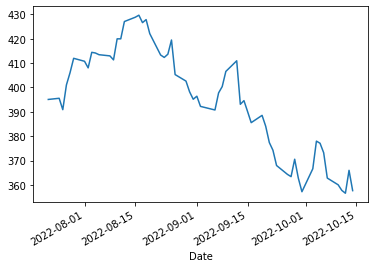

In [4]:
#Ploting temp data
tmp = data.iloc[-60:]
tmp['close'].plot()

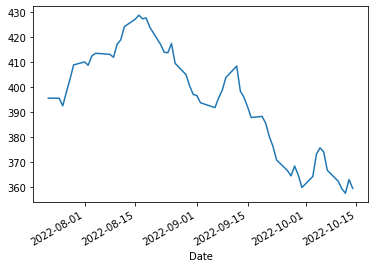

In [5]:
#Definig the function on Feature engineering for technical indicator implimenting
def exponential_smooth(data,alpha):
  return data.ewm(alpha=alpha).mean()

data = exponential_smooth(data,0.65)
temp1 = data.iloc[-60:]
temp1['close'].plot()

In [6]:
#Defining the Function for implimenting the technical indicator

def get_indicator(data):
  for indicator in INDICATOR:
    ind_data = eval('TA.'+indicator+'(data)')
    if not isinstance(ind_data, pd.DataFrame):
      ind_data = ind_data.to_frame()
    data = data.merge(ind_data, left_index=True, right_index=True)
  data.rename(columns={"14 period EMV.":'14 period EMV'},inplace=True)


  #Evaluating the moving average for features
  data['ema50'] = data['close']/data['close'].ewm(50).mean()
  data['ema21'] = data['close']/data['close'].ewm(21).mean()
  data['ema14'] = data['close']/data['close'].ewm(14).mean()
  data['ema5'] = data['close']/data['close'].ewm(5).mean()

  #Normalization of volume
  data['normVol'] = data['volume']/data['volume'].ewm(5).mean()

  #Remove columns that wont be used as features
  del (data['open'])
  del (data['adj_close'])
  del (data['high'])
  del (data['low'])
  del (data['volume'])

  return data

data = get_indicator(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ema50', 'ema21', 'ema14',
       'ema5', 'normVol'],
      dtype='object')


In [7]:
data.tail()

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ema50,ema21,ema14,ema5,normVol
Date,,,,,,,,,,,,,,
2022-10-10 00:00:00-04:00,362.372588,33.850052,-8.517195,-8.857637,13.437246,3.366905e+09,8.667960,-4.238121,34.805675,0.911490,0.938976,0.951609,0.978797,0.860986
2022-10-11 00:00:00-04:00,359.361400,32.064606,-8.800032,-8.846116,8.617879,3.327783e+09,8.520566,-5.149352,35.121410,0.905622,0.934096,0.947257,0.975433,0.927122
2022-10-12 00:00:00-04:00,357.540488,30.999774,-9.066600,-8.890213,4.197324,3.276523e+09,8.406765,-10.882774,35.498703,0.902785,0.932356,0.946086,0.975287,0.864592
2022-10-13 00:00:00-04:00,363.019672,37.703703,-8.735040,-8.859178,43.727430,3.359047e+09,8.801121,-1.741976,43.793741,0.918121,0.948946,0.963115,0.991847,1.252258
2022-10-14 00:00:00-04:00,359.516388,35.339507,-8.655191,-8.818381,30.885027,3.321097e+09,9.267463,-0.317184,51.271261,0.910881,0.942367,0.956766,0.985186,1.143221


In [8]:
#Definig the function for creating truth value columns
def predict_value(data, window):

  prediction = (data.shift(-window)['close']>=data['close'])
  prediction = prediction.iloc[:-window]
  data['pred'] = prediction.astype(int)

  return data

data = predict_value(data, window=15)
del (data['close'])
data = data.dropna()
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ema50,ema21,ema14,ema5,normVol,pred
Date,,,,,,,,,,,,,,
2022-09-19 00:00:00-04:00,35.804989,-4.551135,-2.877188,19.721767,3.586260e+09,7.344292,-5.471407,25.931302,0.953824,0.964995,0.966925,0.980297,0.961225,0.0
2022-09-20 00:00:00-04:00,33.787276,-5.099608,-3.321672,13.432613,3.617621e+09,7.253363,-6.250501,26.051816,0.948066,0.959999,0.962652,0.977708,0.937239,0.0
2022-09-21 00:00:00-04:00,30.233687,-5.895243,-3.836386,4.269369,3.546806e+09,7.458671,-15.441165,25.714764,0.936189,0.949061,0.952595,0.970012,1.123657,0.0
2022-09-22 00:00:00-04:00,27.902469,-6.764206,-4.421950,2.830320,3.481841e+09,7.443243,-22.408410,25.511232,0.927872,0.941874,0.946383,0.966451,1.055179,0.0
2022-09-23 00:00:00-04:00,25.016251,-7.802517,-5.098063,8.052620,3.476837e+09,7.382979,-32.965440,25.245111,0.915977,0.931277,0.936888,0.960067,1.222416,0.0


#**Model Building**

In [9]:
#Defining the function for random forest model
def random_forest(xtrain, ytrain,xtest,ytest):

  #create model
  rf = RandomForestClassifier()

  #Definig the params
  params_rf = {'n_estimators':[110,120,130,140,150,160,170,180,190,200]}

  #Checking all params with GridSearchCV
  rf_gs = GridSearchCV(rf,params_rf,cv=5)

  #Fit the model to train model
  rf_gs.fit(xtrain,ytrain)

  #save best params
  rf_best = rf_gs.best_estimator_

  #Printing the best n_estimator
  print(rf_gs.best_params_)

In [12]:
#Definig the KNN model with function
def KNN_model(xtrain,ytrain,xtest,ytest):

  #Create model of knn
  knn = KNeighborsClassifier()

  #Definig the params for model
  params_knn = {'n_neighbors':np.arrange(1,25)}

  #Checking all params with GridSearchCV
  knn_gs = GridSearchCV(knn, param_grid= params_knn, cv=5)

  #Save the best model
  knn_best = knn_gs.best_estimator_

  #Check the best N_neighbors values
  print(knn_gs.best_params_)



In [13]:
#Splitting the data with crossvalidation
def cross_validation(data):
  num_train = 10
  len_train = 40

  #Defining the list for storing result
  rf_result = []
  knn_result = []
  ensemble = []

  i = 0
  while True:
    df = data.iloc[i*num_train:(i*num_train)+len_train]
    i +=1
    print(i*num_train,(i*num_train)+len_train)

    if len(df)<40:
      break

    y = df['pred']
    features = [x for x in df.columns if x not in ['pred']]
    x = df[features]

    xtrain,ytrain, xtest,ytest = train_test_split(x,y,train_size=7*len(x)//10, shuffle=False)
